# pytorch 常用模块

本文主要结合以下资料，了解除了前述最基本的pytorch用法之外的一些常用必要模块。

目前内容主要包括 [数据处理](#数据处理)、[可视化Tensorboard](#可视化Tensorboard) 以及 [模型保存和加载](#模型保存和加载) 等。

- [WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
- [pytorch/tutorials/beginner_source](https://github.com/pytorch/tutorials/tree/master/beginner_source) 
- [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

## 数据处理

很多时候要花时间在准备数据上，比如网络上下载的纯数据，想要顺利地输入到自己定义的模型中，可能这一步要花些时间来处理。

pytorch提供了许多工具来让数据的夹在更容易，来使代码可读性更强。接下来用一个例子看看如何加载并处理数据。

### 一个例子

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

该数据集是一个面部图片。在这里下载：https://download.pytorch.org/tutorial/faces.zip ，解压后文件夹置于data文件夹下。

首先看看csv数据：

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


展示一个图片看看：

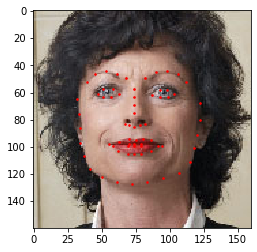

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

torch.utils.data.Dataset 是一个抽象类，代表一个数据集。自己定制的数据集应该继承Dataset 类，并重写__len__ 和__getitem__ 函数。前者是返回数据集的大小，后者用以支持索引dataset[i]来获取第i个sample。

现在为 face landmarks数据集**创建一个dataset类**。在 **__init__ 函数中读取csv文件**，将images的读取放在__getitem__中，这样可以避免一次性将所有数据都加载进内存。

设计数据集的sample为dict：{'image': image, 'landmarks': landmarks}，dataset会设置一个可选参数transform以在需要的时候作用到sample上。transform后面稍后再看。这里先说下基本逻辑，因为原始数据集可能有不同的格式，因此最好可以通过变换变换为统一的格式，因为__getitem__函数实际上是准备模型输入数据，所以transform函数在其中被调用。

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

现在初始化类并迭代数据samples，以4个samples为例：

0 (324, 215, 3) (68, 2)


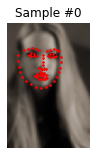

1 (500, 333, 3) (68, 2)


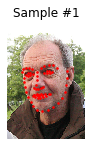

2 (250, 258, 3) (68, 2)


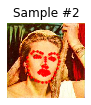

3 (434, 290, 3) (68, 2)


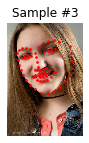

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

从上面的图片中可以看出samples大小是不一样的。而神经网络还是希望输入的数据是大小fixed的，所以需要对数据做预处理：

- Rescale: scale 图片
- RandomCrop: 随机切图. 这是 data augmentation.
- ToTensor: 将numpy的images转换为torch images(需要swap axes).

将它们都写为**可调用的class**，而不是简单的需要在调用时传参的函数。需要实现__call__方法，还有如有需要的__init__函数。然后就可以形如下列模式，直接像函数一样调用对象了：

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

注意看看这些transforms如何应用到images和landmarks上：

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

现在将transform 应用到一个sample上。比如我们想rescale image的较短边到256，并随机切成一个边长224的正方形，所以要使用Rescale 和RandomCrop 变换。torchvision.transforms.Compose 是自带的一个可以执行这些变换的。

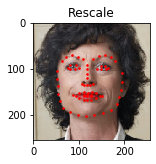

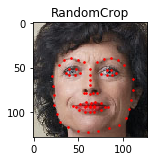

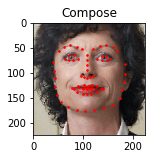

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

现在我们可以应用前面所述工具创建一个转换后的数据集了：

- 快速读取image
- 转换读取的image
- 因为数据转换是随机的，所以数据是增强的

迭代读取数据，在创建Dataset实例时，赋值transform类实例，这样后面调用__getitem()__ 获取模型输入数据时，就会执行变换。

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


不过，由于只是简单地迭代数据，因此我们丢失了很多特征。比如：

- Batching 数据
- Shuffling 数据
- 使用multiprocessing 并行加载数据

torch.utils.data.DataLoader是一个迭代器，能提供上述功能。我们必须得清楚一些参数。其中之一是collate_fn。可以指定样本需要如何被batched。大多数情况下默认的方式即可。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


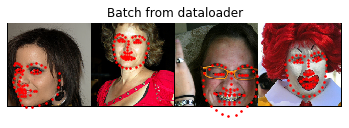

In [10]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True)  # if multi-core cpu ： num_workers=4


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Dataset，DataLoader 与 DataloaderIter

根据网上查的资料总结下dataset，dataloader等的用法。参考资料有：[Pytorch数据读取(Dataset, DataLoader, DataLoaderIter)](https://zhuanlan.zhihu.com/p/30934236),[一文弄懂Pytorch的DataLoader, DataSet, Sampler之间的关系](https://www.cnblogs.com/marsggbo/p/11308889.html),[PyTorch 中自定义数据集的读取方法小结](https://www.pytorchtutorial.com/pytorch-custom-dataset-examples/)

Pytorch的数据读取非常方便, 可以很容易地实现多线程数据预读，而且编程难度不大，灵活性也更高。Pytorch的数据读取主要包含三个类:

- Dataset
- DataLoader
- DataLoaderIter

这三者大致是一个依次封装的关系: 1.被装进2., 2.被装进3.

#### Dataset

torch.utils.data.Dataset是一个抽象类, 自定义的Dataset需要继承它并且实现两个成员方法:

- __getitem__()
- __len__()

第一个最为重要, 即每次怎么读数据，比如对于一个图片：

```python
def __getitem__(self, index):
    img_path, label = self.data[index].img_path, self.data[index].label
    img = Image.open(img_path)

    return img, label
```

可以看到，img是模型训练的输入数据，label是模型训练的输出数据。

第二个比较简单, 就是返回**整个数据集的长度**，比如：

```python
def __len__(self):
    return len(self.data)
```

#### DataLoader 与 DataLoaderIter

torch.utils.data.DataLoader类定义为:

```python
class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)
```

可以看到, 主要参数有这么几个:

- dataset : 即上面自定义的dataset.
- collate_fn: 这个函数用来打包batch, 后面详细讲.
- num_worker: 非常简单的多线程方法, 只要设置为>=1, 就可以多线程预读数据啦.

这个类一共干了两件事: 

1. 定义了一堆成员变量, 到时候赋给torch.utils.data.dataloader.DataLoaderIter 
2. 然后有一个__iter__() 函数, 把自己 "装进" DataLoaderIter 里面.

```python
def __iter__(self):
    return DataLoaderIter(self)
```

现在再自上而下理解下，首先看看 **DataLoaderIter**.__next__ 的源码：

```python
class DataLoaderIter(object):
    ...
    
    def __next__(self):
        if self.num_workers == 0:  
            indices = next(self.sample_iter)  # Sampler
            batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset
            if self.pin_memory:
                batch = _utils.pin_memory.pin_memory_batch(batch)
            return batch
```

稍微解读下这段代码：

首先 indices = next(self.sample_iter) 这句，假设我们的数据是一组图像，每一张图像对应一个index，那么如果我们要读取数据就只需要**对应的index**即可，即代码中的indices,而选取index的方式有多种，有按顺序的，也有乱序的，所以这个工作需要Sampler完成，所以DataLoader和Sampler在这里产生了关系。说白点，就是sampler去选择要哪些数据，假如指定了shuffle=True，那就不必再自己定义sampler了，就是直接打乱取样了，indices就会被shuffle好的。

然后Dataset和DataLoader在什么时候产生关系呢？就是这句：“batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset”。[self.dataset[i] for i in indices] 将选中的数据集拼到一个list里面，然后利用 collate_fn 将这个list的数据组织成想要的 batch 的形式。collate_fn 可以使用默认的，也可以自己写一个。default_collate （在torch.utils.data.\_utils.collate.py中） 注释是：r"""Puts each data field into a tensor with outer dimension batch size""" ， 也就是说batch_size 是最外部的维度。

所以有这样的关系图：

![](img/g79zz9rukh.png)

DataLoader 的源代码如下：

```python
class DataLoader(object):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=default_collate,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None)
```

可以看到初始化参数里有两种sampler：sampler和batch_sampler，都默认为None。前者的作用是生成**一个又一个**的index，而batch_sampler则是将sampler生成的indices打包分组，得到**一个又一个batch**的index。例如下面示例中，BatchSampler将 **SequentialSampler生成的index** **按照指定的batch size分组**。

In [9]:
from torch.utils.data.sampler import BatchSampler
from torch.utils.data.sampler import SequentialSampler, RandomSampler
print(list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False)))
print(list(BatchSampler(RandomSampler(range(10)), batch_size=3, drop_last=False)))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]
[[3, 7, 1], [5, 8, 0], [6, 4, 9], [2]]


Pytorch中已经实现的Sampler有如下几种：

- SequentialSampler
- RandomSampler
- WeightedSampler
- SubsetRandomSampler

需要注意的是DataLoader的部分初始化参数之间存在互斥关系，这里做些总结：

- 如果你自定义了batch_sampler,那么这些参数都必须使用默认值：batch_size, shuffle,sampler,drop_last.
- 如果你自定义了sampler，那么shuffle需要设置为False
- 如果sampler和batch_sampler都为None,那么batch_sampler使用Pytorch已经实现好的BatchSampler,而sampler分两种情况：
    - 若shuffle=True,则sampler=RandomSampler(dataset)
    - 若shuffle=False,则sampler=SequentialSampler(dataset)

最后总结下。

Dataset定义方式前面已说，就不再赘述，总之 __getitem__ 是最主要的方法，它规定了如何读取数据，它是python built-in方法，其主要作用是能让该类可以像list一样通过索引值对数据进行访问。假如你定义好了一个dataset，那么你可以直接通过dataset[0]来访问第一个数据。如果你想对__getitem__方法进行调试，你可以写一个for循环遍历dataset来进行调试了，而不用构建dataloader等一大堆东西了。DataLoader对数据的读取其实就是**用了for循环来遍历数据**。

self.collate_fn方法的参数中：

- indices: 表示每一个iteration，sampler返回的indices，即一个batch size大小的索引列表
- self.dataset[i]: 前面已经介绍了，这里就是对第i个数据进行读取操作，一般来说self.dataset[i]=(img, label)

看到这不难猜出collate_fn的作用就是**将一个batch的数据进行合并操作**。默认的collate_fn是将img和label分别合并成imgs和labels，所以如果你的__getitem__方法只是返回 img, label，那么你可以使用默认的collate_fn方法，但是如果你每次读取的数据有img, box, label等等，那么你就需要自定义collate_fn来将对应的数据合并成一个batch数据，这样方便后续的训练步骤。

最后总结下最简单地使用基本过程，参考：[批训练](https://morvanzhou.github.io/tutorials/machine-learning/torch/3-05-train-on-batch/)

Torch 中提供了一种帮你整理你的数据结构的好东西, 叫做 DataLoader, 我们能用它来包装自己的数据, 进行批训练. 

DataLoader 是 torch 给你用来包装你的数据的工具. 所以你要将自己的 (numpy array 或其他) 数据形式**装换成 Tensor, 然后再放进这个包装器中**. 使用 DataLoader 有什么好处呢? 就是他们帮你有效地迭代数据, 举例如下。其中注释给出了关键步骤。

In [7]:
import torch
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible

BATCH_SIZE = 5      # 批训练的数据个数

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(x, y)

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

Epoch:  0 | Step:  0 | batch x:  [ 5.  7. 10.  3.  4.] | batch y:  [6. 4. 1. 8. 7.]
Epoch:  0 | Step:  1 | batch x:  [2. 1. 8. 9. 6.] | batch y:  [ 9. 10.  3.  2.  5.]
Epoch:  1 | Step:  0 | batch x:  [ 4.  6.  7. 10.  8.] | batch y:  [7. 5. 4. 1. 3.]
Epoch:  1 | Step:  1 | batch x:  [5. 3. 2. 1. 9.] | batch y:  [ 6.  8.  9. 10.  2.]
Epoch:  2 | Step:  0 | batch x:  [ 4.  2.  5.  6. 10.] | batch y:  [7. 9. 6. 5. 1.]
Epoch:  2 | Step:  1 | batch x:  [3. 9. 1. 8. 7.] | batch y:  [ 8.  2. 10.  3.  4.]


当数据是高维时，也没有问题，比如二维的情况，参考：[How to load a list of numpy arrays to pytorch dataset loader?](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader)

In [1]:
import torch
import numpy as np
from torch.utils import data

my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = data.DataLoader(my_dataset) # create your dataloader
for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(my_dataloader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

Epoch:  0 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  0 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]
Epoch:  1 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  1 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]
Epoch:  2 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  2 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]


再比如三维，参考：[Input numpy ndarray instead of images in a CNN](https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np


class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


numpy_data = np.random.randn(100, 3, 24, 24)
numpy_target = np.random.randint(0, 5, size=(100))

dataset = MyDataset(numpy_data, numpy_target)
loader = DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
#     num_workers=2,   # 如果有GPU， 可以取消这两行注释
#     pin_memory=torch.cuda.is_available()
)

for batch_idx, (data, target) in enumerate(loader):
    print('Batch idx {}, data shape {}, target shape {}'.format(
        batch_idx, data.shape, target.shape))

Batch idx 0, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 1, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 2, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 3, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 4, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 5, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 6, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 7, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 8, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 9, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])


不过要注意关键是如何使用loop送入模型训练，读取的数据的形式一定要能和模型所需的输入匹配。

另外，如果要使用的数据本身来自多个点的时间序列，那么sample就需要两个维度了。注意不论什么时候都不要提前拼装好数据，因为那样数据量会比较大，要等到后面__getitem__的时候再取数据，避免内存浪费。

接下来参考：[Building Efficient Custom Datasets in PyTorch](https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f)，给出一个完整的各种类型数据的示例，这个例子是处理文本文件制作数据集，利用Dataset和Dataloader。

## 可视化Tensorboard

可以展示模型训练时的一些统计指标以对训练过程有基本的认识。Pytorch现在整合了TensorBoard，它是一个设计来可视化神经网络训练过程结果的工具。有了它可以可视化更丰富的内容。tensorboard 是pytorch官方推荐的工具，它来自tensorflow的可视化工具箱。可以参考：[TensorBoard: TensorFlow's visualization toolkit](https://www.tensorflow.org/tensorboard/)，查看更多细节。其基本功能包括以下内容等：

- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data

另外，根据[Welcome to tensorboardX’s documentation!](https://tensorboardx.readthedocs.io/en/latest/index.html) 介绍，pytorch中应是使用的tensorboradx来作为调用tensorboard的工具。

接下来是一个例子，首先读取数据并做合适的变换。接着**设置tensorboard并将数据写入tensorboard**，然后就可以使用tensorboard了，包括查看训练数据，跟踪模型训练性能，以及评估训练后的模型性能。

In [11]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

# 注意test时候的dataloader是不用shuffle的。
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

26427392it [00:01, 13368522.49it/s]                             


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


32768it [00:00, 84290.76it/s]                            


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


4423680it [00:01, 3457450.37it/s]                            


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


8192it [00:00, 33182.46it/s]            


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


以上是数据的前处理，接下来构建网络模型：

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

建立event writer 实体在纪录任何东西之前，我们需要**建立一个event writer 实体**，具体而言就是开始设置tensorboard时，先从torch.utils导入并定义**SummaryWriter**，这是向tensorboard写数据的关键对象，SummaryWriter 是一个类别，包含tensorboard套件的所有功能。 runs/fashion_mnist_experiment_1 是一个被建立的文件夹，TensorBoard 对象会被放入其中。接下来要写入任何资料都是**调用writer.add_xxx()**，xxx表示某功能。

注意子目录 fashion_mnist_experiment_1。每个子目录都会被视为一个实验。每次执行新的实验时，比如说改了一些参数，这时请将资料夹重新命名，像是：runs/exp2, runs/myexp这样可以便于比较实验的结果。

建立writer实体之后就可以开始纪录了，API的长相大概是：add_xxx(标签，要記錄的東西，時間戳，其他參數)。更多内容可以参考：[Tutorials_zh](https://tensorboardx.readthedocs.io/en/latest/tutorial_zh.html)

如果你的pytorch版本是1.1, 1.2，那么需要手动安装tensorboard，如果更低版本，那么建议升级吧。安装tensorboard的方法可以参考：[Using TensorBoard with PyTorch 1.1 or 1.2](https://www.endtoend.ai/blog/pytorch-tensorboard/)。如果使用了pipenv，也可以使用pipenv安装。注意报错的话，详细查看文中的安装细节。比如我遇到的错误：ModuleNotFoundError: No module named 'past'，然后安装future： pipenv install future 即可。

In [13]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

创建了新的文件夹runs/fashion_mnist_experiment_1之后，接下来把数据写入 TensorBoard，因为这里是图片，所以使用make_grid 。

其实最直接的还是记录純数据量，其方法是 writer.add_scalar('myscalar', value, iteration)， value 可以是 PyTorch tensor ， numpy或是 float，int 之類的python原生數字類別。稍后在训练过程中有记录。这里先看图片。

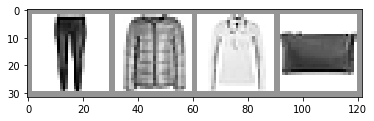

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

现在在runs文件夹的上一级文件夹下打开命令行并运行：

```Shell
tensorboard --logdir=runs
```

然后就可以导航到 https://localhost:6006 查看交互式图形了。

tensorboard的一个亮点是能可视化复杂的模型结构。它需要两个参数：神经网络模型 以及 你要喂给他的 tensor，令模型為 m，輸入為 x，則使用方法為： add_graph(m, (x, )) 這裡使用 tuple 的原因是當网络有多個輸入時，可以把他擴充成 add_graph(m, (x, y, z)) ，如果只有單一輸入，寫成 add_graph(m, x) 也無妨。注意如果輸入是 cpu tensor，model 在 GPU 上，或者反过来，那么该函数就会报错。

In [16]:
writer.add_graph(net, images)
writer.close()

执行完上面命令后，刷新TensorBoard，就会看到网页导航栏有“GRAPHS”。点击进入，就能看到模型结构，双击每个节点，就能看到内部的结构。

接下来看看如何通过add_embedding方法来可视化高维数据为低维表示。

In [17]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

接下来将loss记录进TensorBoard，并通过plot_classes_preds函数看模型预测。首先是一些辅助函数：

In [18]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

然后训练模型，并使用add_scalar函数将结果写入TensorBoard，而不是输出到控制台。前面已经提到过记录纯数据的add_scalar函数了，这里稍微展开一点。

純数据量是最好記錄的東西。通常我們會把每次訓練的損失loss記錄下來或者是測試的準確度accuracy，都是值得記錄的東西。其他數據，像是學習率learning rate也值得紀錄。 紀錄纯数据的方法是 writer.add_scalar('myscalar', value, iteration)， value 可以是 PyTorch tensor ， numpy或是 float，int 之類的python原生數字類別。

另外就是绘制图表，用 matplotlib 畫了美美的圖表想紀錄？請用 add_figure 。傳入的对象是 matplotlib 的 figure。

In [19]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


现在在SCALARS标签下可以看到训练过程中loss的变化。最后可以看看如何评估模型。在新的标签页可以看到结果。

In [10]:
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

## 模型保存和加载

这部分主要参考官方文档；[SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)，pytorch中有三个核心函数和模型保存及加载有关。

- torch.save: 保存一个序列化的对象到disk中。该函数使用了 Python’s pickle 功能来实现序列化. 使用该函数可以保存 Models, tensors, and dictionaries of all kinds of objects
- torch.load: 使用了 pickle’s unpickling 功能来反序列化 pickled object files 到内存中.该函数还支持跨设备加载数据，后面有记录.
- torch.nn.Module.load_state_dict: 用反序列化的 state_dict 加载 model’s parameter dictionary.

什么是state_dict?

在pytorch中，torch.nn.Module 模型的可学习参数在 model’s parameters 存放，通过model.parameters() 可以访问。state_dict 就是一个简单的python 字典数据对象，将每层都对应到它的参数张量中。注意仅仅是有可学习参数的层以及registered buffers（batchnorm’s running_mean）有state_dict的项。  Optimizer objects (torch.optim)也有state_dict，它包含了optimizer’s 状态的信息以及使用的超参数。

接下来是一个例子：

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# Define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


可以看到在model 和 optimizer 中，各有一个state_dict。

如何保存和加载模型？

Save/Load state_dict 是官方文档推荐的做法。

保存:

In [6]:
PATH = 'model_stat_dict_save.pt'
torch.save(model.state_dict(), PATH)

加载模型：

In [7]:
model = TheModelClass()
model.load_state_dict(torch.load(PATH))
model.eval()

TheModelClass(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

保存模型时，保存模型的可学习参数就足够了。使用torch.save保存模型可以给加载模型提供足够的灵活度，保存的文件的后缀名约定一般是.pt 或者 .pth

注意一定要调用 model.eval() 来设置dropout和batch normalization层 以在运行推断前评估模型。忘记做这个会导致不一致的结果。

pytorch也提供了直接保存和加载整个模型的功能：

保存：

```python
torch.save(model, PATH)
```

加载：

```python
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()
```

这种方法的缺点是保存模型时将序列化的数据绑定到使用的特定类和精确的目录结构，这样做的原因是pickle并不保存模型类本身，相反，它保存了包含类的文件的路径，在加载时使用。因此，在其他项目中使用或重构之后，您的代码可能会以各种方式中断。

可以使用来自不同模型的参数热启动模型，这是便于迁移学习等的。如果是不同的模型来加载一个模型保存的参数，需要设置 strict参数为False。更多解释可以参考：https://discuss.pytorch.org/t/does-model-load-state-dict-strict-false-ignore-new-parameters-introduced-in-my-models-constructor/84539

下面以MNIST数字识别举例说明：

In [131]:
import torch
import torchvision

# 这里仅仅简单训练下
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.manual_seed(random_seed)

下载并加载数据，第一次下载会花费一些时间！

In [132]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [133]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

下面定义网络

In [134]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

netA = NetA()

class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc3 = nn.Linear(320, 60)
        self.fc4 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return F.log_softmax(x)

netB = NetB()

先留存一下原始参数，以便与后面load A的参数后的netB去比较。

**注意**如果不deep copy的话，param是会跟着后面的情况一起变的，这样后续就没办法比较了

In [135]:
import copy
parmA_origin={}
for name,parameters in netA.named_parameters():
    parmA_origin[name]=copy.deepcopy(parameters.detach().numpy())

In [136]:
parmB_origin={}
for name,parameters in netB.named_parameters():
    parmB_origin[name]=copy.deepcopy(parameters.detach().numpy())

In [137]:
parmA_origin['conv1.weight'][0,:,:,:]

array([[[ 0.08461933, -0.09999173,  0.19312711, -0.01542597,
          0.01249917],
        [-0.0485514 ,  0.0818745 , -0.11873768,  0.11920632,
         -0.10647666],
        [-0.1927936 , -0.07043846,  0.10304068,  0.15853785,
         -0.18278408],
        [ 0.19492532, -0.1941947 ,  0.14813651, -0.03630249,
         -0.14956605],
        [-0.1576112 ,  0.08923613,  0.04742368,  0.1032802 ,
         -0.18679936]]], dtype=float32)

接下来训练一下netA以便更新权重，否则A和B初始化都一致的话，后面以netA的权重热启动B的时候看不出区别了

In [138]:
optimizer = optim.SGD(netA.parameters(), lr=learning_rate,
                      momentum=momentum)

In [139]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [140]:
def train(epoch):
    netA.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = netA(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(netA.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [141]:
for epoch in range(1, n_epochs + 1):
    train(epoch)

C:\Users\11445\miniconda3\envs\hydrus\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309525
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.022175
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.119666
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.832731
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.634668
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.891181
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.674287
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.608813
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.533669
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.336423


可以看到模型已经保存到 model.pth中了。

读取一下netA的某些权值，方便后面的比较。

In [142]:
parmA={}
for name,parameters in netA.named_parameters():
    print(name,':',parameters.size())
    parmA[name]=parameters.detach().numpy()

conv1.weight : torch.Size([10, 1, 5, 5])
conv1.bias : torch.Size([10])
conv2.weight : torch.Size([20, 10, 5, 5])
conv2.bias : torch.Size([20])
fc1.weight : torch.Size([50, 320])
fc1.bias : torch.Size([50])
fc2.weight : torch.Size([10, 50])
fc2.bias : torch.Size([10])


In [143]:
parmA['conv1.weight'][0,:,:,:]

array([[[ 0.03816791, -0.09063213,  0.25794375,  0.05282231,
          0.02740593],
        [-0.07874528,  0.11591165, -0.02044236,  0.19382551,
         -0.11824302],
        [-0.17865203,  0.00801876,  0.20999166,  0.22586595,
         -0.21723759],
        [ 0.20170559, -0.11268231,  0.2561097 ,  0.01857063,
         -0.17813924],
        [-0.11874139,  0.16501632,  0.13521025,  0.14605242,
         -0.19817369]]], dtype=float32)

In [144]:
parmA_origin['conv1.weight'][0,:,:,:] == parmA['conv1.weight'][0,:,:,:]

array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]]])

可以看到经过训练，A的权值已经发生了变化，下面把训练后的参数加载到B网络中，注意strict参数要设置成False，否则会直接报错

In [145]:
netB.load_state_dict(torch.load('model.pth'), strict=False)

_IncompatibleKeys(missing_keys=['fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'], unexpected_keys=['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

for name,parameters in netA.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.detach().numpy()

看看netB的一些权重数据

In [146]:
parmB={}
# 一个deep copy，用于后面和迁移学习后的参数比较
parmB_before_tl={}
for name,parameters in netB.named_parameters():
    print(name,':',parameters.size())
    parmB[name]=parameters.detach().numpy()
    parmB_before_tl[name]=copy.deepcopy(parameters.detach().numpy())

conv1.weight : torch.Size([10, 1, 5, 5])
conv1.bias : torch.Size([10])
conv2.weight : torch.Size([20, 10, 5, 5])
conv2.bias : torch.Size([20])
fc3.weight : torch.Size([60, 320])
fc3.bias : torch.Size([60])
fc4.weight : torch.Size([10, 60])
fc4.bias : torch.Size([10])


In [147]:
parmB['conv1.weight'][0,0,:,:] == parmA['conv1.weight'][0,0,:,:]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [148]:
parmB['conv1.weight'][0,0,:,:] == parmB_origin['conv1.weight'][0,0,:,:]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [149]:
parmB['fc4.weight'][0,:] == parmB_origin['fc4.weight'][0,:] 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

经过上面的比较可以看到，同名的层会自动从A中加载参数过来，而不同名的没法预加载参数，就仍保持了初始化值。

如果想要freeze某些层，可以通过将特定层的参数的requires_grad设置为False来实现。

通过 .children() 函数可以查看 model 的各个层。

In [150]:
for child in netB.children():
    print(child)
#     for param in child.parameters():
#         print(param)

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Dropout2d(p=0.5, inplace=False)
Linear(in_features=320, out_features=60, bias=True)
Linear(in_features=60, out_features=10, bias=True)


可以通过 param.requires_grad = False 的方式来 freeze 参数，但是这种方式，不是很方便制定特定的层。使用下面的方式可以指定某些层，但是注意nn.Module是没有 requires_grad 属性的，所以直接对layer使用这个是不行的，这样会直接创建一个requires_grad属性，但是这个属性没用，该层参数后面还是会更新：

In [151]:
netB.conv1.requires_grad = False
print(type(netB.conv1))
print(type(netB.conv1.weight))
netB.conv1.weight.requires_grad

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.parameter.Parameter'>


True

需要直接对有requires_grad属性的Parameter对象--weight和bias使用如下命令：

In [152]:
# we want to freeze the conv layer
netB.conv1.weight.requires_grad = False
netB.conv1.bias.requires_grad = False
netB.conv2.weight.requires_grad = False
netB.conv2.bias.requires_grad = False

或者使用如下方式以在需要外部输入字符串来表示执行对象时实现freeze的目的：

In [153]:
exec("netB."+"conv1.weight"+".requires_grad = False")
exec("netB."+"conv1.bias"+".requires_grad = False")
exec("netB."+"conv2.weight"+".requires_grad = False")
exec("netB."+"conv2.bias"+".requires_grad = False")

In [154]:
print(netB.conv1.weight.requires_grad)
print(netB.conv1.bias.requires_grad)
print(netB.conv2.weight.requires_grad)
print(netB.conv2.bias.requires_grad)
print(netB.fc3.weight.requires_grad)
print(netB.fc3.bias.requires_grad)
print(netB.fc4.weight.requires_grad)
print(netB.fc4.bias.requires_grad)

False
False
False
False
True
True
True
True


In [155]:
optimizerB = optim.SGD(netB.parameters(), lr=learning_rate,
                      momentum=momentum)

In [156]:
netB.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizerB.zero_grad()
    output = netB(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizerB.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

C:\Users\11445\miniconda3\envs\hydrus\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.534606
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.939074
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.696478
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.440061
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.406974
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.409463
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.361660
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.596876
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.652949
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.319642


In [157]:
parmB_before_tl['conv1.weight'][0,0,:,:] == parmB['conv1.weight'][0,0,:,:]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [158]:
parmB_before_tl['fc3.weight'][0,:] == parmB['fc3.weight'][0,:] 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

再训练netB，可以看到freeze的部分权值没有变化，其他部分是变化了的。